In [5]:
import os
os.environ['PYTENSOR_FLAGS'] = 'floatX=float32'

import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers
from laos_gggi.data_functions.combine_data import load_all_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib
import pytensor


import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load

configure_plot_style()

# Load data


In [4]:
model_data = pd.read_csv("../data/HSGP_full_model_data.csv")
laos_points = pd.read_csv("../data/laos_points.csv")

# Model helper functions

In [27]:
# Standardize function
def standardize(df: pd.DataFrame):
    df_standardized = (df - df.mean())/df.std()
    return df_standardized

In [6]:
#Define data function
def add_data(features: list[str], df: pd.DataFrame, add_time :bool = False, target: str | None = None, name = None, dims=None, dtype=None):
    X_name = 'X' if name is None else f'X_{name}'
    Y_name = 'Y' if name is None else f'Y_{name}'
    
    if dtype is None:
        dtype = pytensor.config.floatX
        
    with pm.modelcontext(None):
        X = pm.Data(X_name, df[features].astype(dtype), dims=dims)
        
        if target is not None:
            Y = pm.Data(Y_name, df[target].astype(dtype), dims=dims[0] if dims is not None else dims)
            return X, Y
        
    return X

#Add country fixed effect function
def add_country_effect():
    with pm.modelcontext(None):
        country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
        country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
        country_effect_offset = pm.ZeroSumNormal('country_effect_offset', sigma=1, dims="ISO")
        country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
        
    return country_effect


# Model

In [7]:
model_data

,Unnamed: 0,log_distance_to_river,log_distance_to_coastline,Population,co2,precip_deviation,dev_ocean_temp,log_population_density,log_population_density_squared,log_gdp_per_cap,...,ORD_FLOW_1,ORD_FLOW_2,ORD_FLOW_3,ORD_FLOW_4,ISO,Start_Year,is_disaster,is_island,lat,long
0,1,0.028039,-1.482335,-0.431146,-0.942276,0.885975,1.372957,0.383423,0.383423,-1.054729,...,0.0,0.0,0.0,1.0,SEN,1999-01-01,0,False,15.487992,-16.622313
1,2,0.416235,-0.593646,-0.431146,-0.942276,0.885975,1.372957,0.383423,0.383423,-1.054729,...,0.0,0.0,0.0,1.0,SEN,1999-01-01,0,False,14.916956,-16.568934
2,3,-0.103971,-1.473752,-0.431146,-0.942276,0.885975,1.372957,0.383423,0.383423,-1.054729,...,0.0,0.0,0.0,1.0,SEN,1999-01-01,0,False,13.735641,-16.529269
3,4,0.371747,-1.434536,-0.458336,-1.580429,-0.035128,-0.708141,0.225088,0.225088,-1.419601,...,0.0,0.0,0.0,1.0,GNB,1993-01-01,0,False,12.367295,-16.340863
4,5,-0.063451,-0.804628,-0.431146,-0.942276,0.885975,1.372957,0.383423,0.383423,-1.054729,...,0.0,0.0,0.0,1.0,SEN,1999-01-01,0,False,12.946229,-16.308788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63132,71131,-0.061000,-2.135941,-0.293908,1.630052,0.984052,-0.644767,0.745799,0.745799,-0.808478,...,0.0,0.0,0.0,1.0,KEN,2020-01-01,1,False,-2.162000,40.900400
63133,71132,0.187388,0.505898,-0.293908,1.630052,0.984052,-0.644767,0.745799,0.745799,-0.808478,...,0.0,0.0,0.0,1.0,KEN,2020-01-01,1,False,0.420700,37.574300
63134,71133,0.343803,0.230931,-0.293908,1.630052,0.984052,-0.644767,0.745799,0.745799,-0.808478,...,0.0,0.0,0.0,1.0,KEN,2020-01-01,1,False,-1.848500,38.074300
63135,71134,0.096899,0.489373,-0.293908,1.630052,0.984052,-0.644767,0.745799,0.745799,-0.808478,...,0.0,0.0,0.0,1.0,KEN,2020-01-01,1,False,0.350100,37.682500


In [8]:
#Define features
distance_features_2 = ['log_distance_to_river', 'log_distance_to_coastline', 'is_island', "ORD_FLOW_1",
                       "ORD_FLOW_2", "ORD_FLOW_3", "ORD_FLOW_4"]

time_varying_features_2 = ["Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

In [9]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_data["is_disaster"])
ISO_idx, ISO = pd.factorize(model_data["ISO"]) 
obs_idx = model_data.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_data.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_2 = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "distance_features": distance_features_2,
        "time_varying_features" : time_varying_features_2,
        "gp_feature":gp_features }


In [148]:
floatX = pytensor.config.floatX

with pm.Model(coords=coords_2) as HSGP_full_model:
    #Declare data
    geographic_data, Y = add_data(features= distance_features_2,  
                                  target = "is_disaster", 
                                  df = model_data, 
                                  dims=['obs_idx', 'features'])
    economic_data = add_data(features = time_varying_features_2,  
                             target = None, 
                             df = model_data, 
                             name='time_varying',
                             dims=['obs_idx', 'time_varying_features'])
    
    X_gp = pm.Data("X_gp", model_data[["lat", "long"]].astype(floatX), 
                   dims=['obs_idx', 'gp_feature'])
    iso_idx_pt = pm.Data('ISO_idx', ISO_idx, dims=['obs_idx'])

    #Country effect
#     country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])
    country_effect = add_country_effect()

    #Betas
    geographic_betas = pm.Normal("geographic_betas", mu = 0, sigma = 1, dims = ["distance_features"])
    economic_betas = pm.Normal("economic_betas", mu = 0, sigma = 1, dims = ["time_varying_features"])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 20, 20, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
#     HSGP_component = pm.Deterministic("HSGP_component", (phi * (basis_coeffs * sqrt_psd).sum(axis=-1)).sum(axis=-1), dims=['obs_idx'])
#     geographic_component = pm.Deterministic('geographic_component', (geographic_data * geographic_betas).sum(axis=-1), dims=['obs_idx'])
#     economic_component = pm.Deterministic('economic_component', (economic_data * economic_betas).sum(axis=-1), dims=['obs_idx'])
    HSGP_component = phi @ (basis_coeffs * sqrt_psd)
    geographic_component = geographic_data @ geographic_betas
    economic_component = economic_data @ economic_betas
    
    #Model mu
#     logit_p = pm.Deterministic('logit_p', country_effect[iso_idx_pt] + geographic_component + economic_component + HSGP_component, dims=['obs_idx'])
    logit_p = country_effect[iso_idx_pt] + geographic_component + economic_component + HSGP_component

    y_hat = pm.Bernoulli('y_hat', logit_p = logit_p, observed=Y, dims='obs_idx')
    HSGP_full_model_ord_flow_idata = pm.sample(nuts_sampler='numpyro', 
                      nuts_sampler_kwargs={'chain_method':'vectorized'},
                      chains=4, 
                      draws=500)

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/pytensor/link/jax/dispatch/tensor_basic.py:174: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x, dtype=op.dtype)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3

  0%|                                                                                          | 0/1500 [00:00<?, ?it/s]/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/pytensor/link/jax/dispatch/tensor_basic.py:174: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#cur

sample: 100%|███████████████████████████████████████████████████████████████████████| 1500/1500 [49:32<00:00,  1.98s/it]
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/pytensor/link/jax/dispatch/tensor_basic.py:174: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x, dtype=op.dtype)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  

In [43]:
# from pymc.model.transform.optimization import freeze_dims_and_data
# compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(HSGP_full_model), backend="jax", gradient_backend='jax')
# HSGP_full_model_idata = nutpie.sample(compiled_model)

In [ ]:
#Save the idata
az.to_netcdf(data = HSGP_full_model_ord_flow_idata, filename= pathlib.Path("HSGP_full_model_ord_flow_idata"))

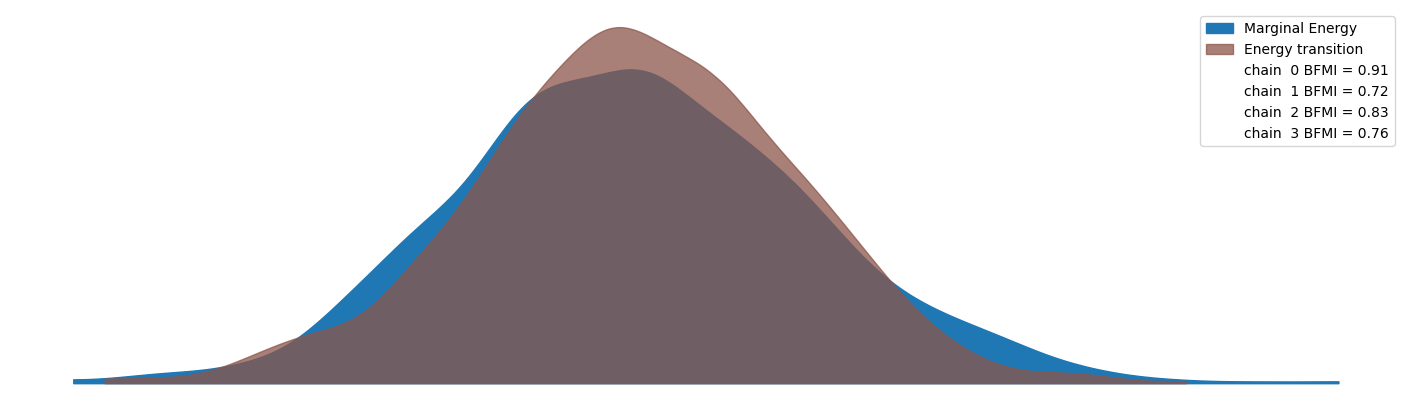

In [149]:
az.plot_energy(HSGP_full_model_ord_flow_idata);

In [150]:
print(az.summary(HSGP_full_model_ord_flow_idata, var_names=[ 'geographic_betas', 'economic_betas', 'eta', 'ell']).to_string())

                                                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
geographic_betas[log_distance_to_river]         -0.250  0.022  -0.291   -0.210      0.000    0.000    3573.0    1500.0   1.00
geographic_betas[log_distance_to_coastline]     -0.907  0.037  -0.977   -0.838      0.001    0.000    3899.0    1636.0   1.00
geographic_betas[is_island]                     -0.399  0.935  -2.048    1.487      0.035    0.025     728.0     975.0   1.02
economic_betas[Population]                      -3.063  0.266  -3.588   -2.588      0.006    0.004    2073.0    1680.0   1.00
economic_betas[co2]                              0.139  0.047   0.050    0.222      0.001    0.001    1287.0    1714.0   1.00
economic_betas[precip_deviation]                 0.101  0.025   0.055    0.146      0.000    0.000    3396.0    1572.0   1.00
economic_betas[dev_ocean_temp]                   0.289  0.016   0.259    0.318      0.000    0.000    3655.0    1310.0

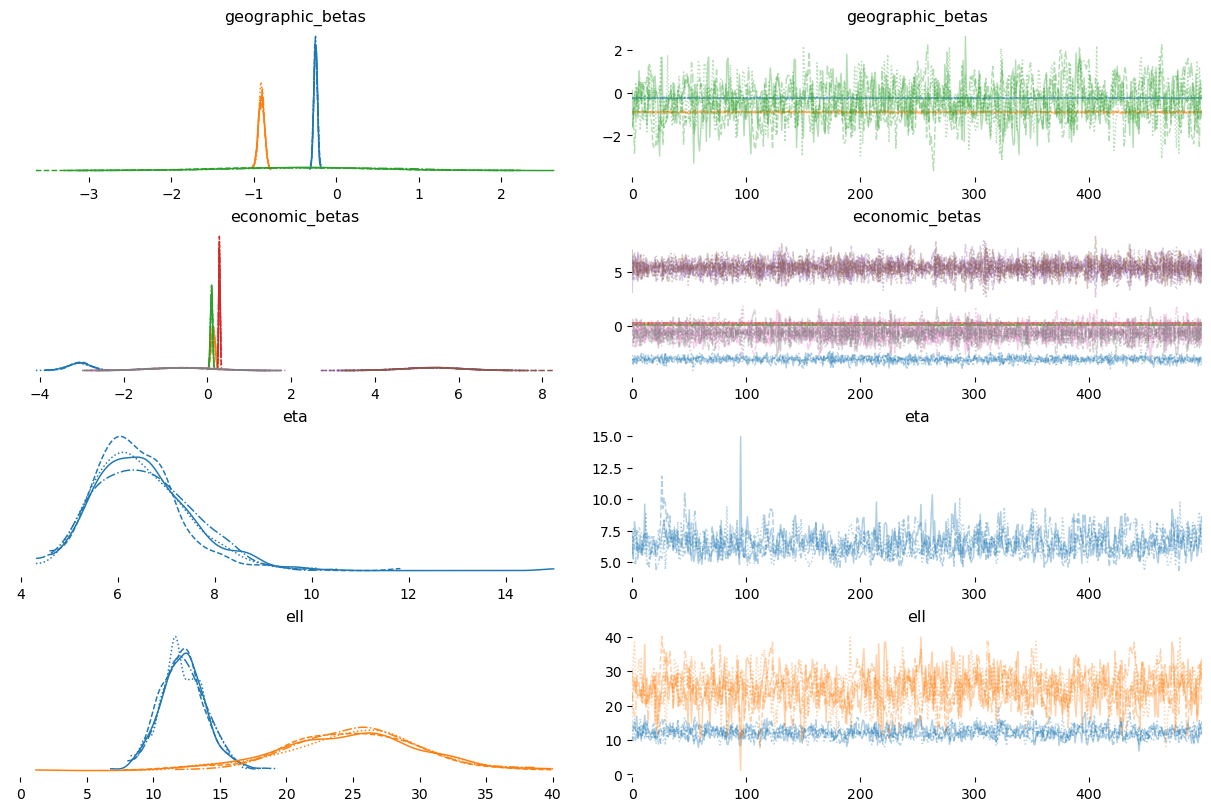

In [151]:
az.plot_trace(HSGP_full_model_ord_flow_idata, var_names=[ 'geographic_betas', 'economic_betas', 'eta', 'ell']);

# Lao Predictions

In [152]:
laos_grid_2d = np.array(laos_points[["lat", "lon"]])

In [153]:
laos_data_by_year = model_df_2.query('ISO == "LAO"')[time_varying_features_2 + ['Start_Year']].drop_duplicates().set_index('Start_Year').sort_index()

In [381]:
ref_year = '2020'
laos_idx = ISO.tolist().index('LAO')
laos_points = laos_points.assign(ISO = 'LAO', Start_Year = f'{ref_year}-01-01', is_disaster=0)
laos_points = laos_points.rename(columns={'lon':'long'})

laos_data_by_year.loc[ref_year]
for col in time_varying_features_2:
    laos_points[col] = laos_data_by_year.loc[ref_year, col].item()


In [382]:
laos_plot_data = pd.DataFrame(pipeline.transform(laos_points),
                              index=laos_points.index,
                              columns=[x.split('__')[-1] for x in pipeline.get_feature_names_out()])

In [383]:
def compute_center(X):
    return (pt.max(X, axis=0) + pt.min(X, axis=0)).eval() / 2

In [384]:
from copy import deepcopy
from pymc.model.transform.optimization import freeze_dims_and_data
plot_coords = deepcopy(coords_2)
plot_coords['obs_idx'] = np.arange(laos_plot_data.shape[0])

with pm.Model(coords=plot_coords) as HSGP_full_model_plot:
    geographic_data = add_data(features= distance_features_2 ,  target = None, df =  laos_plot_data, dims=['obs_idx', 'features'])
    economic_data = add_data(features = time_varying_features_2 ,  target = None, df =  laos_plot_data, name='time_varying', dims=['obs_idx', 'time_varying_features'])
    X_gp = pm.Data("X_gp", laos_plot_data[["lat", "long"]].astype(floatX), dims=['obs_idx', 'gp_feature'])

    #Country effect
    country_effect = pm.Flat("country_effect", dims = ["ISO"])    

    #Betas
    geographic_betas = pm.Flat("geographic_betas", dims = ["distance_features"])
    economic_betas = pm.Flat("economic_betas", dims = ["time_varying_features"])

    # Prior on the HSGP
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 20, 20, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    gp._X_center = compute_center(model_data[["lat", "long"]].astype(floatX))

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    HSGP_component = pm.Deterministic('HSGP_component', phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])
    geographic_component = pm.Deterministic('geographic_component', geographic_data @ geographic_betas, dims=['obs_idx'])
    economic_component = pm.Deterministic('economic_component', economic_data @ economic_betas, dims=['obs_idx'])
    
    logit_p = pm.Deterministic('logit_p', country_effect[laos_idx] + geographic_component + economic_component + HSGP_component, dims=['obs_idx'])
    p = pm.Deterministic('p', pm.math.invlogit(logit_p), dims=['obs_idx'])
    
    
with freeze_dims_and_data(HSGP_full_model_plot):
    idata_plot = pm.sample_posterior_predictive(HSGP_full_model_ord_flow_idata, extend_inferencedata=False, compile_kwargs={'mode':'JAX'},
                                                var_names=['HSGP_component', 'geographic_component', 'economic_component', 'logit_p', 'p'])

Sampling: []


Output()

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: 
UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to 
dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell 
environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)

In [385]:
#Store df of predictions
HSGP_full_model_predictions = idata_plot.posterior_predictive.mean(dim=("chain", "draw")).to_dataframe()

#Merge predictions with Laos points
HSGP_full_model_predictions = pd.merge(HSGP_full_model_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
HSGP_full_model_predictions_geo = gpd.GeoDataFrame(
                HSGP_full_model_predictions,
    geometry=gpd.points_from_xy(HSGP_full_model_predictions["long"],
                                HSGP_full_model_predictions["lat"]),crs="EPSG:4326"
            )

In [386]:
# with HSGP_full_model:
#     pm.set_data({'X': laos_plot_data[distance_features_2].values.astype(float),
#                  'Y': np.zeros(laos_plot_data.shape[0]),
#                  'X_time_varying': laos_plot_data[time_varying_features_2].values.astype(float),
#                  'X_gp': laos_plot_data[['lat', 'long']].astype(float).values,
#                  'ISO_idx':np.full(laos_plot_data.shape[0], laos_idx)},
#                 coords={'obs_idx': laos_plot_data.index.values})
# with freeze_dims_and_data(HSGP_full_model):
#     idata_laos = pm.sample_posterior_predictive(HSGP_full_model_idata, extend_inferencedata=False, compile_kwargs={'mode':'JAX'})

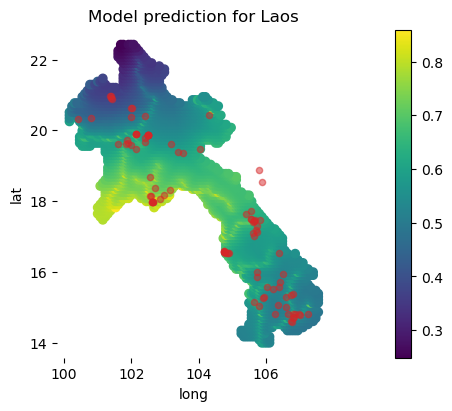

In [387]:
#Plot the predictions
fig, ax = plt.subplots()
HSGP_full_model_predictions_geo.plot("p",legend=True, ax=ax)
model_df_2.query('ISO == "LAO" & is_disaster == 1').plot.scatter(x='long', y='lat', ax=ax, c='tab:red', alpha=0.5)
plt.title("Model prediction for Laos", );

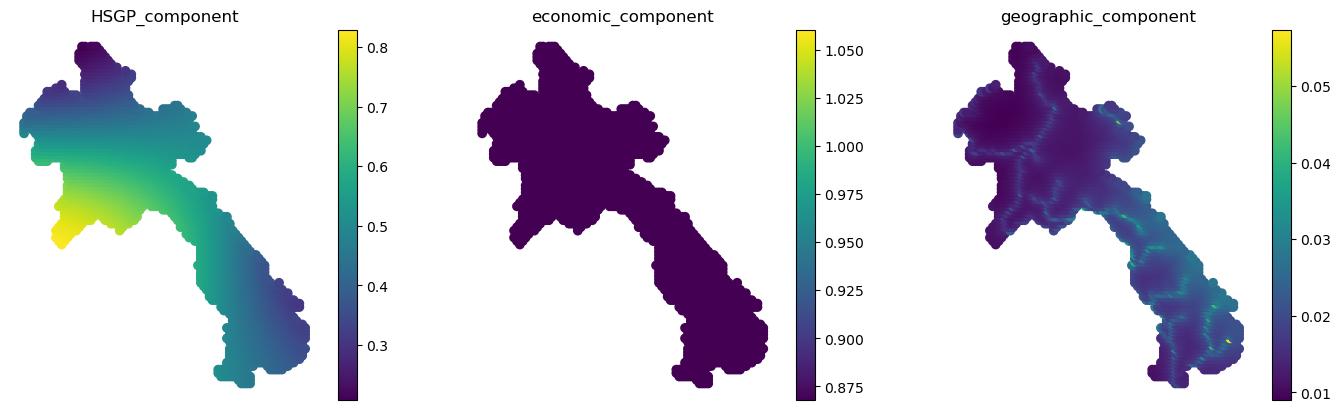

In [388]:
from scipy.special import expit
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for name, axis in zip(['HSGP_component', 'economic_component', 'geographic_component'], fig.axes):
    temp = expit(idata_plot.posterior_predictive[name]).mean(dim=['chain', 'draw']).to_dataframe()
    temp = pd.merge(temp, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

    #Transform into geo Data Frame
    temp = gpd.GeoDataFrame(
                    temp,
        geometry=gpd.points_from_xy(HSGP_full_model_predictions["long"],
                                    HSGP_full_model_predictions["lat"]),crs="EPSG:4326"
                )
    temp.plot(name, legend=True, ax=axis)
    axis.set_title(name)
    axis.axis('off')
plt.show()

# South-East Asis

In [285]:
sea_codes = ['BRN', 'KHM', 'IDN', 'LAO', 'MYS', 'MMR', 'PHL', 'SGP', 'THA', 'TLS', 'VNM']
SEA = world.query('ISO_A3 in @sea_codes')
sea_points = create_grid_from_shape(SEA, rivers, coastline, grid_size=200)

  0%|          | 0/7582 [00:00<?, ?it/s]

  0%|          | 0/7582 [00:00<?, ?it/s]

In [389]:
ref_year = '2020'
sea_points = sea_points.assign(Start_Year = pd.to_datetime(f'{ref_year}-01-01'), 
                               is_disaster=0,
                               is_island = lambda x: x.ISO.apply(island_dict.get))
sea_points_merged = pd.merge(sea_points, 
                             model_df_2[time_varying_features_2 + ['ISO', 'Start_Year']].drop_duplicates(), 
                             left_on=['ISO', 'Start_Year'],
                             right_on=['ISO', 'Start_Year'],
                             how='left')
sea_points_merged = pd.DataFrame(pipeline.transform(sea_points_merged),
                                 index=sea_points_merged.index,
                                 columns=[x.split('__')[-1] for x in pipeline.get_feature_names_out()])
sea_iso_idx = sea_points_merged.ISO.apply(lambda x: ISO.tolist().index(x) if x in ISO else None)
missing = sea_iso_idx.isna()
sea_points_merged = sea_points_merged.loc[~missing]
sea_iso_idx = sea_iso_idx[~missing].astype(int)
# for col in time_varying_features_2:
#     laos_points[col] = laos_data_by_year.loc[ref_year, col].item()

# laos_points = laos_points.assign(ISO = 'LAO', Start_Year = f'{ref_year}-01-01', is_disaster=0)
# laos_points = laos_points.rename(columns={'lon':'long'})

# laos_data_by_year.loc[ref_year]
# for col in time_varying_features_2:
#     laos_points[col] = laos_data_by_year.loc[ref_year, col].item()


In [391]:
from copy import deepcopy
from pymc.model.transform.optimization import freeze_dims_and_data
plot_coords = deepcopy(coords_2)
plot_coords['obs_idx'] = np.arange(sea_points_merged.shape[0])

with pm.Model(coords=plot_coords) as HSGP_full_model_plot:
    geographic_data = add_data(features= distance_features_2 ,  target = None, df =  sea_points_merged, dims=['obs_idx', 'features'])
    economic_data = add_data(features = time_varying_features_2 ,  target = None, df =  sea_points_merged, name='time_varying', dims=['obs_idx', 'time_varying_features'])
    X_gp = pm.Data("X_gp", sea_points_merged[["lat", "long"]].astype(floatX), dims=['obs_idx', 'gp_feature'])
    iso_idx_pt = pm.Data('iso_idx_pt', sea_iso_idx.values, dims=['obs_idx'])
    
    #Country effect
    country_effect = pm.Flat("country_effect", dims = ["ISO"])    

    #Betas
    geographic_betas = pm.Flat("geographic_betas", dims = ["distance_features"])
    economic_betas = pm.Flat("economic_betas", dims = ["time_varying_features"])

    # Prior on the HSGP
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 20, 20, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    gp._X_center = compute_center(model_data[['lat', 'long']].values.astype(floatX))

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    HSGP_component = pm.Deterministic('HSGP_component', phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])
    geographic_component = pm.Deterministic('geographic_component', geographic_data @ geographic_betas, dims=['obs_idx'])
    economic_component = pm.Deterministic('economic_component', economic_data @ economic_betas, dims=['obs_idx'])
    
    logit_p = pm.Deterministic('logit_p', country_effect[iso_idx_pt] + geographic_component + economic_component + HSGP_component, dims=['obs_idx'])
    p = pm.Deterministic('p', pm.math.invlogit(logit_p), dims=['obs_idx'])

with freeze_dims_and_data(HSGP_full_model_plot):
    idata_plot_SEA = pm.sample_posterior_predictive(HSGP_full_model_ord_flow_idata, extend_inferencedata=False, compile_kwargs={'mode':'JAX'},
                                                var_names=['HSGP_component', 'geographic_component', 'economic_component', 'logit_p', 'p'])

Sampling: []


Output()

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: 
UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to 
dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell 
environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)

In [392]:
idx = xr.Coordinates.from_pandas_multiindex(pd.MultiIndex.from_frame(sea_points_merged[['long', 'lat']]), 'obs_idx')

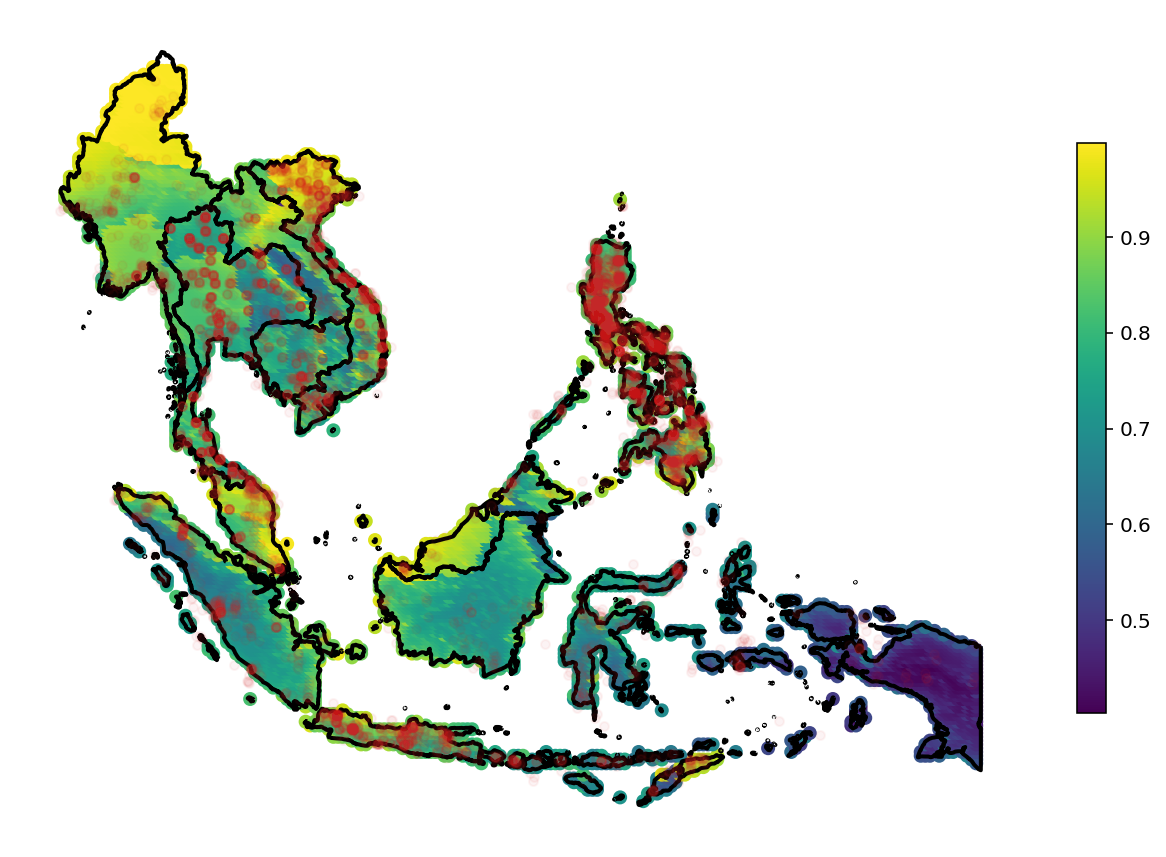

In [407]:
# fig, ax = plt.subplots(figsize=(8, 8), dpi=144, subplot_kw={'aspect':'equal'})
#Store df of predictions
sea_preds = idata_plot_SEA.posterior_predictive.mean(dim=("chain", "draw")).to_dataframe()

#Merge predictions with Laos points
sea_preds = pd.merge(sea_preds, sea_points_merged, 
                     left_index=True, right_index=True,
                     how = "left")

#Transform into geo Data Frame
sea_preds_geo = gpd.GeoDataFrame(
                sea_preds,
    geometry=gpd.points_from_xy(sea_preds["long"],
                                sea_preds["lat"]),crs="EPSG:4326"
            )

fig, ax = plt.subplots(figsize=(8, 8), dpi=144, subplot_kw={'aspect':'equal'})
sea_preds_geo.plot('p', legend=True, ax=ax, legend_kwds={'shrink':0.5})
SEA.plot(facecolor='none', edgecolor='k', lw=2, ax=ax)
data.query('is_disaster == 1 & ISO in @sea_codes').plot.scatter(x='long', y='lat', color='tab:red', alpha=0.05, ax=ax)
ax.axis('off')
plt.show()

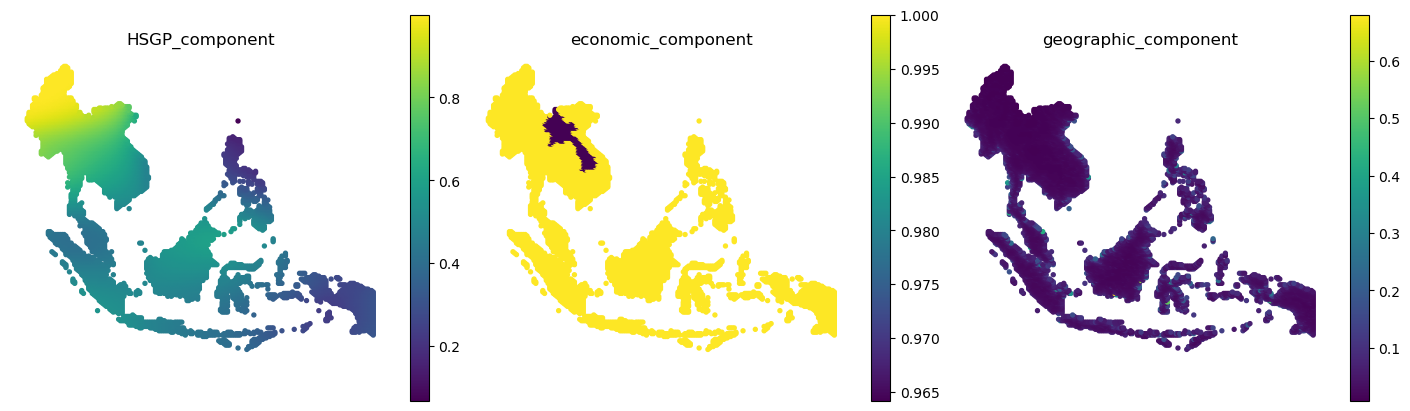

In [409]:
from scipy.special import expit
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for name, axis in zip(['HSGP_component', 'economic_component', 'geographic_component'], fig.axes):
    temp = expit(idata_plot_SEA.posterior_predictive[name]).mean(dim=['chain', 'draw']).to_dataframe()
    temp = pd.merge(temp, sea_points_merged, 
                                       left_index=True, right_index=True,
                                       how = "left")

    #Transform into geo Data Frame
    temp = gpd.GeoDataFrame(
                    temp,
        geometry=gpd.points_from_xy(sea_points_merged["long"],
                                    sea_points_merged["lat"]),crs="EPSG:4326"
                )
    temp.plot(name, legend=True, ax=axis, markersize=8)
    axis.set_title(name)
    axis.axis('off')
plt.show()